# Demo of `columnsfmri` 
## Simulation and optimization of fMRI of cortical columns

Import model implementation from columnsfmri.py and other useful modules.

In [1]:
import columnsfmri

%matplotlib inline
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Inititialize simulation using a 512 x 512 grid on an area of 24 x 24 mm. 

In [2]:
N = 512; L = 24
s = columnsfmri.sim(N,L)

Simulate a column pattern by filtering Gaussian white noise. Rho is the main pattern frequency, delta specifies the amount of irregularity.

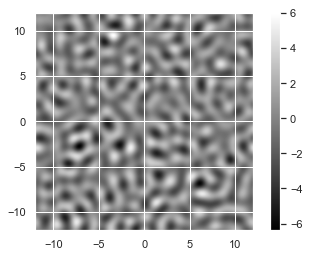

In [3]:
gwn = s.gwnoise()
rho,deltaRelative = 0.5,0.5
columnPattern = s.columnPattern(rho,deltaRelative,gwn)
s.plotPattern(columnPattern)

Simulate a spatial BOLD response with a FWHM of 2 mm, and an average response amplitude of 5%.

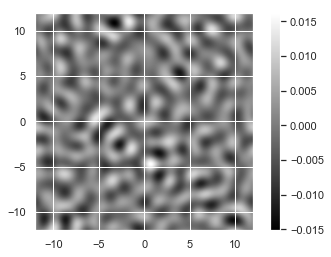

In [4]:
fwhm = 2
beta = 0.05
boldPattern,_,_ = s.bold(fwhm,beta,columnPattern)
s.plotPattern(boldPattern)

Simulate MRI sampling using a voxel width of 3 mm. (We first add the relative response pattern to a constant background of 1).

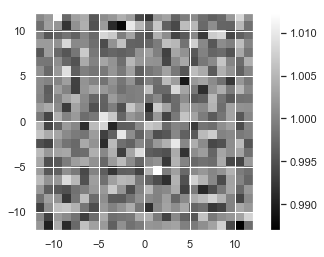

In [5]:
w = 1
mriPattern = s.mri(w,1+boldPattern)
s.plotVoxels(mriPattern)

The amount of functional contrast can be quantified as the standard deviation of the imaged responses (contrast range).

In [6]:
c = np.std(mriPattern)
print(str(100*c)+"%")

0.4058219021531422%


Simulate the noise level as a function of voxel width.

In [7]:
w = np.linspace(0.1,3,100)
V = w**3
TR = 2
nT = 100
differentialFlag = True
noiseType = '3T'
SNR = 1/columnsfmri.noiseModel(V,TR,nT,differentialFlag,noiseType=noiseType)

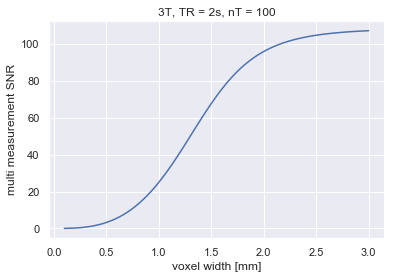

In [8]:
plt.plot(w,SNR)
plt.xlabel('voxel width [mm]')
plt.ylabel('multi measurement SNR')
plt.title('3T, TR = 2s, nT = 100')
plt.show()

Calculate detection probability from CNR and number of voxels.

In [9]:
CNR = 1
nVoxels = 10
columnsfmri.detectionProbability(CNR,nVoxels)

0.5175987740899441

Calculate the correlation between the original and the (interpolated) imaged pattern.

In [10]:
s.patternCorrelation(columnPattern,mriPattern)

0.5981864406543227

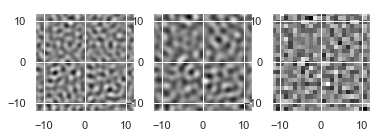

In [11]:
s.plotColumnsBoldMRI(columnPattern,boldPattern,mriPattern)

In [22]:
from ipywidgets import interactive, interact, interact_manual

N = 512; L = 24
s = columnsfmri.sim(N,L)
gwn = s.gwnoise()
rho,deltaRelative = 0.5,0.5
fwhm = 2
beta = 0.05
w = 1

def f(rho,deltaRelative,fwhm,w):
    columnPattern = s.columnPattern(rho,deltaRelative,gwn)
    boldPattern,_,_ = s.bold(fwhm,beta,columnPattern)
    mriPattern = s.mri(w,1+boldPattern)
    s.plotColumnsBoldMRI(columnPattern,boldPattern,mriPattern)

In [24]:
interact(f,rho=[0.1,0.2,0.4,0.8,1.6,3.2],
      deltaRelative=[0.01, 0.25, 0.5, 0.75, 1],
      fwhm=[0.01, 0.5, 1, 1.5, 2,2.5, 3, 3.5],
      w=[0.25,0.5,1,1.5,2,3]);

interactive(children=(Dropdown(description='rho', options=(0.1, 0.2, 0.4, 0.8, 1.6, 3.2), value=0.1), Dropdown…